In [ ]:
# http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

# 需要处理为HDF5格式的数据集

In [ ]:
# https://github.com/makeyourownneuralnetwork/gan/blob/master/10_celeba_download_make_hdf5.ipynb
import torchvision.datasets
mnist_dataset = torchvision.datasets.CelebA(root='.', download=True)

# the above codes cost a lot time, so I do not use this


In [3]:
import h5py
import zipfile
import imageio
import os

#%%time

img_folder  = r"C:\projects\study-deep-learning\gan\CelebA\Img"

# location of the HDF5 package, yours may be under /gan/ not /myo_gan/
hdf5_file = os.path.join(img_folder, 'celeba_aligned_small.h5py') 

if os.path.exists(hdf5_file):
    print(f"already exists: {hdf5_file}")
else:
    img_align_zip = os.path.join(img_folder, 'img_align_celeba.zip')

    # how many of the 202,599 images to extract and package into HDF5
    total_images = 20000

    with h5py.File(hdf5_file, 'w') as hf:

        count = 0

        with zipfile.ZipFile(img_align_zip, 'r') as zf:
            for i in zf.namelist():
                if (i[-4:] == '.jpg'):
                    # extract image
                    ofile = zf.extract(i)
                    img = imageio.imread(ofile)
                    os.remove(ofile)
                    # add image data to HDF5 file with new name
                    hf.create_dataset('img_align_celeba/'+str(count)+'.jpg', data=img, compression="gzip", compression_opts=9)
                    count = count + 1
                    if (count%1000 == 0):
                        print("images done .. ", count)
                    # stop when total_images reached
                    if (count == total_images):
                        break

C:\Users\ben7276\AppData\Local\Temp\ipykernel_43384\3061738266.py:27: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ofile)


images done ..  1000
images done ..  2000
images done ..  3000
images done ..  4000
images done ..  5000
images done ..  6000
images done ..  7000
images done ..  8000
images done ..  9000
images done ..  10000
images done ..  11000
images done ..  12000
images done ..  13000
images done ..  14000
images done ..  15000
images done ..  16000
images done ..  17000
images done ..  18000
images done ..  19000
images done ..  20000


In [5]:
# let get more information about hdf5 file
with h5py.File(hdf5_file, 'r') as hf:
    print(hf.keys())
    print(hf['img_align_celeba/0.jpg'])
    for group in hf:
        print(group)


<KeysViewHDF5 ['img_align_celeba']>
<HDF5 dataset "0.jpg": shape (218, 178, 3), type "|u1">
img_align_celeba


In [6]:
import matplotlib.pyplot as plt
import numpy as np


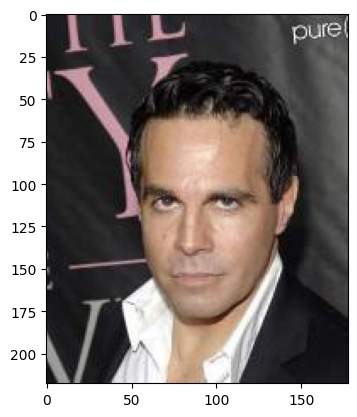

In [7]:
with h5py.File(hdf5_file, "r") as hf:
    dataset = hf['img_align_celeba']
    image_7 = dataset['7.jpg']
    plt.imshow(image_7)

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import pandas as pd

In [55]:
class CelebAdataset(Dataset):
    def __init__(self, file):
        self.file_object = h5py.File(file, 'r')
        self.dataset = self.file_object['img_align_celeba']
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        if index >= len(self.dataset):
            raise IndexError
        img = np.array(self.dataset[str(index)+'.jpg']) 
        return torch.cuda.FloatTensor(img) / 255.0

    def plot_image(self, index):
        if index >= len(self.dataset):
            raise IndexError
        img = np.array(self.dataset[str(index)+'.jpg']) 
        plt.imshow(img)

20000


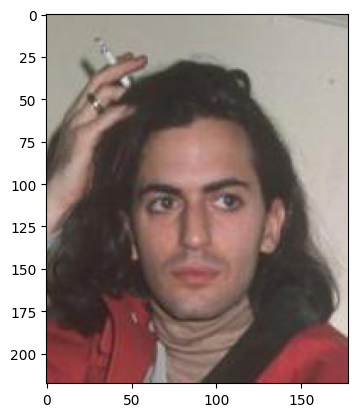

In [62]:
celeba_dataset = CelebAdataset(hdf5_file)
print(len(celeba_dataset))
celeba_dataset.plot_image(2000)

In [34]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

device

device(type='cuda')

In [35]:
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(self.shape)


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        # define the network
        self.model = nn.Sequential(
            View(218*178*3),
            nn.Linear(218*178*3, 100),
            nn.LeakyReLU(),
            nn.LayerNorm(100),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )

        # define the loss function
        self.loss_function = nn.MSELoss()

        # define the optimiser
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

        # define the counter
        self.count = 0
        self.progress = []

    def forward(self, inputs):
        return self.model(inputs)
    
    def train(self, inputs, targets):
        outputs = self.forward(inputs)
        loss = self.loss_function(outputs, targets)

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        self.count += 1

        if self.count % 10 == 0:
            self.progress.append(loss.item())

            if self.count % 1000 == 0:
                print("counter = ", self.count)

    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16, 8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))

In [36]:
def generate_random_image():
    # return gpu tensor
    return torch.rand(218, 178, 3).to(device)

x = generate_random_image()
x.device

device(type='cuda', index=0)

In [63]:
# have a try with Discriminator
D = Discriminator()
D.to(device)

for image_tensor_data in celeba_dataset:
    # give real image
    D.train(image_tensor_data, torch.cuda.FloatTensor([1.0]))
    # give random image
    D.train(generate_random_image(), torch.cuda.FloatTensor([0.0]))

counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000


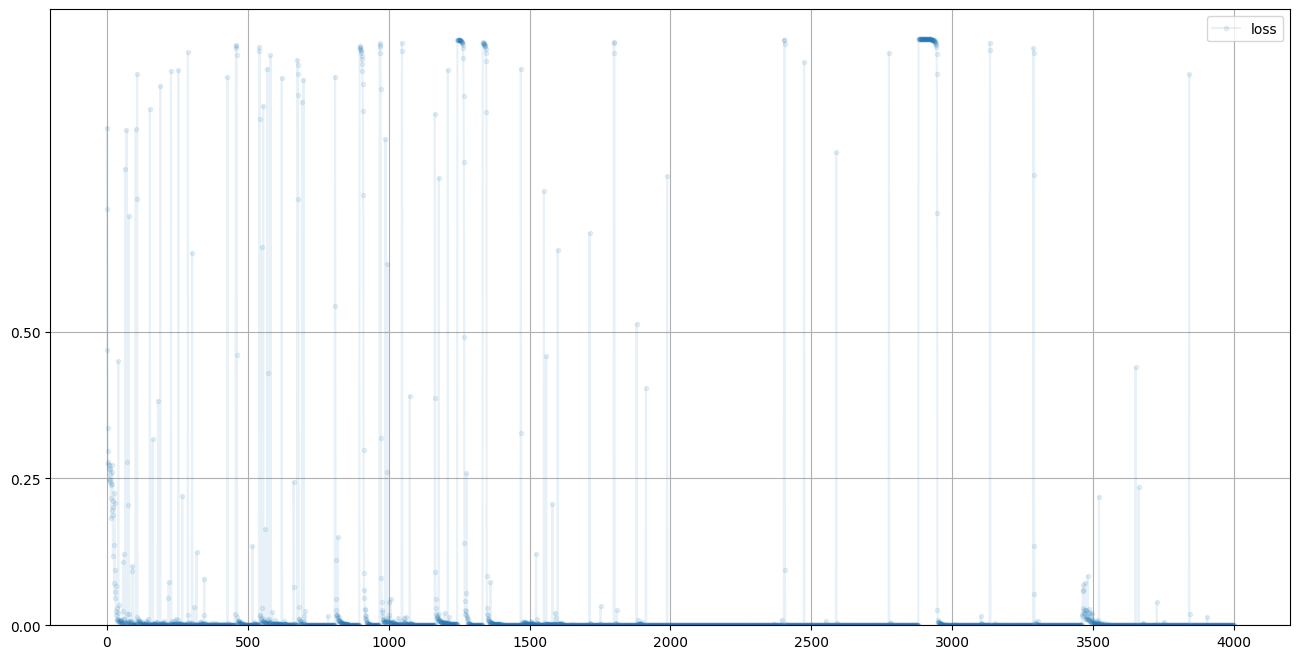

In [64]:
D.plot_progress()

In [47]:
class Generator(nn.Module):

    def __init__(self):
        super().__init__()

        # define the network
        self.model = nn.Sequential(
            nn.Linear(100, 3*10*10),
            nn.LeakyReLU(),
            nn.LayerNorm(3*10*10),
            nn.Linear(3*10*10, 3*218*178),
            nn.Sigmoid(),
            View((218, 178, 3))
        )

        # define the optimiser
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

        # define the counter
        self.count = 0
        self.progress = []

    def forward(self, inputs):
        return self.model(inputs)

    def train(self, D, inputs, targets):
        g_outputs = self.forward(inputs)

        d_outputs = D.forward(g_outputs)

        loss = D.loss_function(d_outputs, targets)

        self.count += 1

        if self.count % 10 == 0:
            self.progress.append(loss.item())

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16, 8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.8))


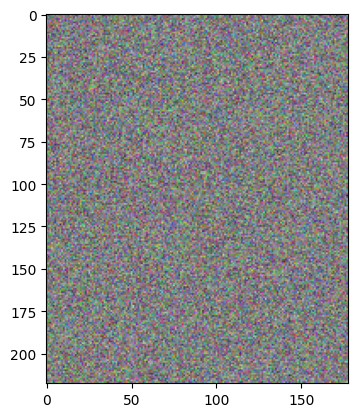

In [69]:
G = Generator()
G.to(device)

def generate_random_seed():
    return torch.randn(100).to(device)

output = G.forward(generate_random_seed())
image = output.cpu().detach().numpy()
plt.imshow(image)

In [71]:
D = Discriminator()
D.to(device)

G = Generator()
G.to(device)

epochs = 1

for epoch in range(epochs):
    print("epoch = ", epoch)
    for image_tensor_data in celeba_dataset:
        # train discriminator on real image
        D.train(image_tensor_data, torch.cuda.FloatTensor([1.0]))
        # train discriminator on fake image
        D.train(G.forward(generate_random_seed().detach()), torch.cuda.FloatTensor([0.0]))
        # train generator
        G.train(D, generate_random_seed(), torch.cuda.FloatTensor([1.0]))

epoch =  0
counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000


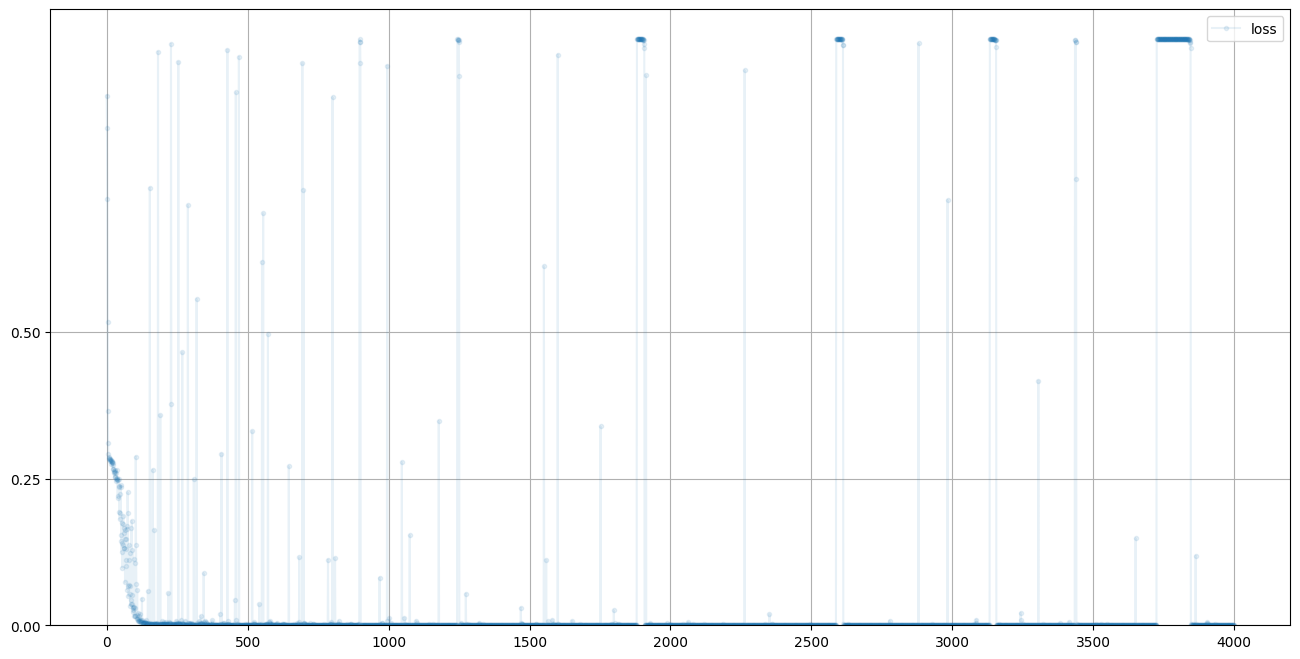

In [72]:
D.plot_progress()

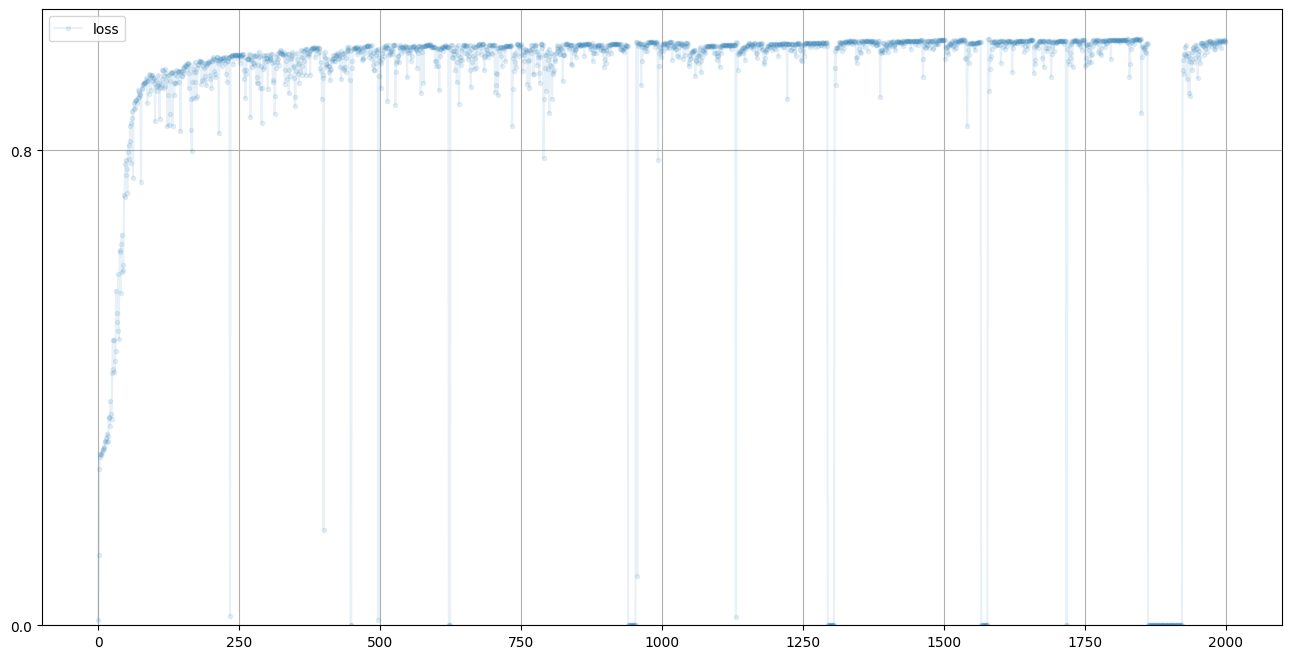

In [73]:
G.plot_progress()

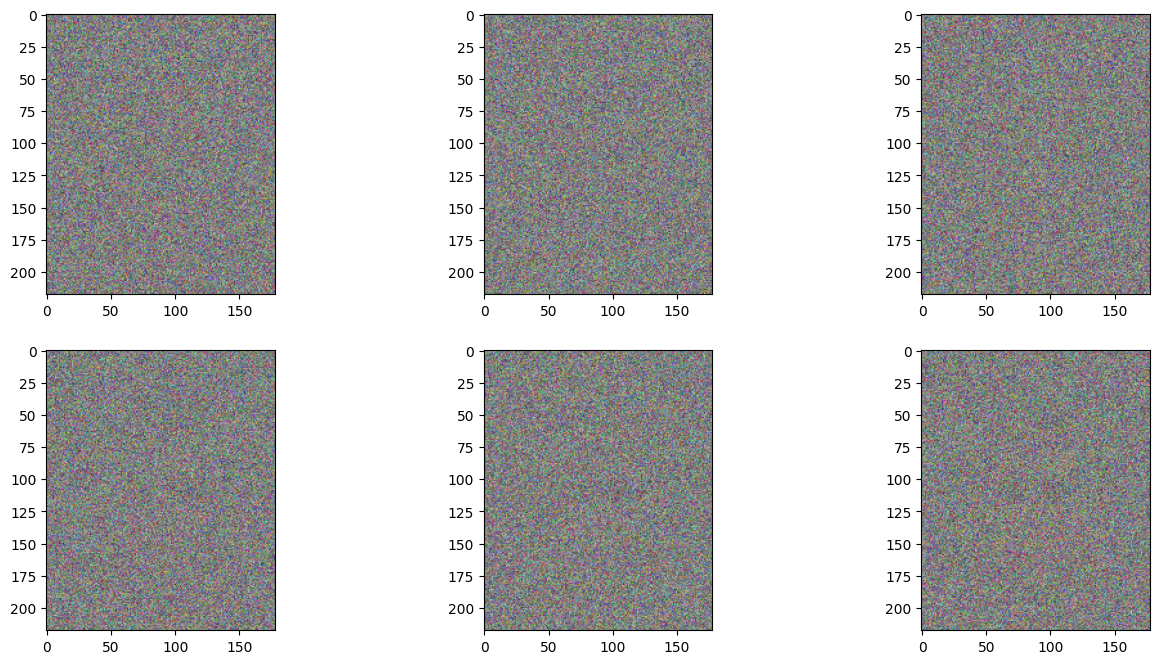

In [74]:
f, axarr = plt.subplots(2, 3, figsize=(16, 8))
for i in range(2):
    for j in range(3):
        axarr[i, j].imshow(G.forward(generate_random_seed()).cpu().detach().numpy())
        